# Analytics 
## Ciências de Dados
### Prof. Dr. Neylson Crepalde

---

## Regressão Logística - Titanic

Hoje vamos brincar com os famosos dados do Titanic para explorar as chances de sobrevivência das pessoas.
Primeiro vamos importar a tabela e ver os dados que temos à disposição para trabalhar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,\
                            accuracy_score, confusion_matrix, auc

In [2]:
# Importando de um repositório no github
titanic = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def freq(x: pd.Series, plot=False):
    contagem = x.value_counts()
    percentual = round((x.value_counts() / x.shape[0]) * 100, 3)
    res = pd.DataFrame({'values': x.unique(), 'n': contagem, 'perc': percentual})
    if plot:
        sns.countplot(x)
        plt.show()
    return res

In [4]:
# Quantos sobreviveram e não sobreviveram
(titanic.Survived.value_counts() / titanic.shape[0]) * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

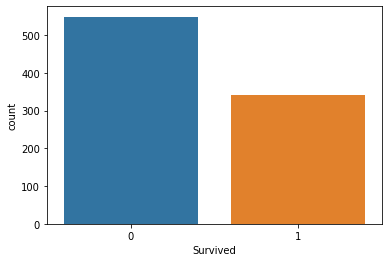

,values,n,perc
0,0,549,61.616
1,1,342,38.384


In [5]:
freq(titanic.Survived, plot=True)

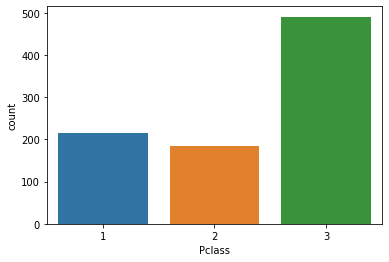

,values,n,perc
3,3,491,55.107
1,1,216,24.242
2,2,184,20.651


In [6]:
freq(titanic.Pclass, plot=True)

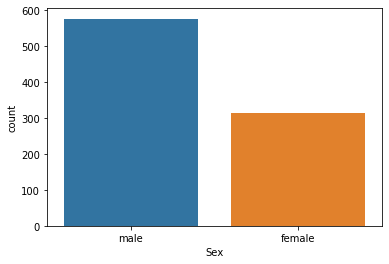

,values,n,perc
male,male,577,64.759
female,female,314,35.241


In [7]:
freq(titanic.Sex, plot=True)

In [8]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

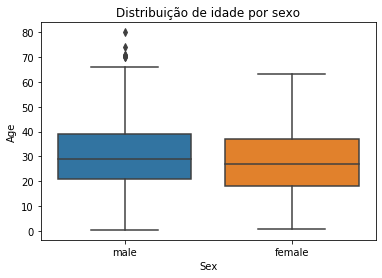

In [9]:
sns.boxplot(x='Sex', y='Age', data=titanic)
plt.title('Distribuição de idade por sexo')
plt.show()

---
# Modelagem

Agora vamos estimar uma regressão logística para investigar as chances de sobrevivência das pessoas dados 3 preditores:

- a **idade** da pessoa;
- a **classe** em que a pessoa viajava e
- o **sexo** da pessoa.

O modelo terá essa configuração:

$$logit = ln \left( \frac{p}{1-p} \right) = \beta_0 + \beta_1 idade + \beta_2 classe2 + \beta_3 classe3 + \beta_4 female$$

Vamos lá:

In [10]:
# Transforma classe em categorico
titanic['Pclass'] = titanic['Pclass'].astype('category')

In [11]:
modelo = smf.glm(formula='Survived ~ Age + Pclass + Sex', data=titanic, 
                family = sm.families.Binomial()).fit()
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      709
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.64
Date:                Sun, 10 Nov 2019   Deviance:                       647.28
Time:                        12:15:43   Pearson chi2:                     767.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7770      0.401      9.416      

Agora, vamos interpretar os resultados do modelo. Os logits estimados só podem ser interpretados em termos de aumento ou diminuição de chances de sobrevivência já que estão em escala logarítmica. Todos os coeficientes estimados foram estatisticamente significativos (p-valor abaixo de 0.05 adotando 95% de confiança).

Pessoas que viajavam na segunda classe possuem menos chances de sobrevivência do que quem viajava na primeira. Quem viajava na terceira classe possui menos chances ainda. Homens possuem menos chances de sobrevivência do que mulheres. Quanto mais velho, menores as chances de sobrevivência. Estas são as intuições gerais do modelo.

Para obtermos coeficientes mais interpretáveis, precisamos fazer uma transformação. Utilizando $e^\beta$ obtemos as chances relativas.

In [12]:
print(np.exp(modelo.params[1:]))

Pclass[T.2]    0.269874
Pclass[T.3]    0.075727
Sex[T.male]    0.080236
Age            0.963690
dtype: float64


Pessoas que viajavam na segunda classe tinham 0.27 das chances de sobrevivência que as pessoas da primeira classe tinham. Pessoas da terceira classe tinham 0.076 das chances que as pessoas da primeira classe tinham. Homens tinham 0.08 das chances das mulheres. 

Para cada ano a mais de sobrevivência o indivíduo fica com 0.96 das chances de outro indivíduo com um ano a menos.

Podemos também gerar os mesmos dados em percentuais relativos de chances para compará-los e obter uma interpretação parecida com a interpretação da regressão linear, mas em termos de chances.

In [13]:
(np.exp(modelo.params[1:]) - 1) * 100

Pclass[T.2]   -73.012578
Pclass[T.3]   -92.427336
Sex[T.male]   -91.976383
Age            -3.630967
dtype: float64

Agora ficou fácil. Pessoas da segunda classe tem 73% menos chances de sobrevivência do que pessoas da primeira classe. Pessoas da terceira classe tem 92% menos chances de sobrevivência que pessoas da primeira classe. Homens tem 92% menos chances de sobrevivência do que mulheres. 

Para cada ano a mais de idade, as chances diminuem 3.63%.

Agora vamos refazer o modelo utilizando scikit-learn para maior facilidade de obter as métricas de ajuste.

In [14]:
# Agora vamos fazer com sklearn para aproveitar as métricas
model = LogisticRegression(penalty='none', solver='newton-cg')
baseline_df = titanic[['Survived', 'Pclass', 'Sex', 'Age']].dropna()
y = baseline_df.Survived
X = pd.get_dummies(baseline_df[['Pclass', 'Sex', 'Age']], drop_first=True)
print(X)

      Age  Pclass_2  Pclass_3  Sex_male
0    22.0         0         1         1
1    38.0         0         0         0
2    26.0         0         1         0
3    35.0         0         0         0
4    35.0         0         1         1
..    ...       ...       ...       ...
885  39.0         0         1         0
886  27.0         1         0         1
887  19.0         0         0         0
889  26.0         0         0         1
890  32.0         0         1         1

[714 rows x 4 columns]


In [15]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
print(model.coef_) # Temos o mesmo modelo!

[[-0.03698519 -1.30979451 -2.58062095 -2.52277985]]


In [17]:
# Predizendo as probabilidades
yhat = model.predict_proba(X)

In [18]:
yhat = yhat[:, 1] # manter somente para a classe positiva

---
# Métricas

Agora vamos avaliar a qualidade do ajuste de nosso modelo. A maioria das métricas de avaliação de modelos de classificação que temos à disposição partem da *matriz de confusão*, uma matriz onde visualizamos os acertos e erros do modelo. Obtemos a matriz de confusão tabulando os valores observados (linhas) e os valores preditos (colunas). Ela possui, então a seguinte configuração:

|            | Pred 0 | Pred 1 |
|------------|--------|--------|
| **Real 0** | TN     | FN     |
| **Real 1** | FP     | TP     |

Onde TP (*True Positives*) são os "uns" que o modelo acertou,
FP (*False Positives*) são os "uns" que o modelo errou (predisse como 0 - ERRO DO TIPO 1),
TN (*True Negatives*) são os zeros que o modelo acerto e 
FN (*False Negatives*) são os zeros que o modelo errou (predisse como 1 - ERRO DO TIPO 2).

Vejamos a matriz de confusão do modelo que estimamos:

In [19]:
confusion_matrix(y, model.predict(X)) # usando a função do sklearn

array([[356,  68],
       [ 83, 207]], dtype=int64)

In [20]:
pd.crosstab(y, model.predict(X))  # fazendo "na mão"

col_0,0,1
Survived,,
0,356,68
1,83,207


As métricas que vamos utilizar podem ser sintetizadas na figura abaixo:

![](metricas_class.png)
Fonte: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

Vamos começar com a `acurácia`. Ela representa um percentual total de acertos do modelo.

In [21]:
acuracia = accuracy_score(y, model.predict(X))
print('O modelo obteve %0.4f de acurácia.' % acuracia)

O modelo obteve 0.7885 de acurácia.


A acurácia não é uma medida muito boa para trabalhar com modelos de classificação pois ela pode nos induzir a achar que um modelo que prediz corretamente todos os *zeros* mas nenhum *um* é um modelo muito bom. Vejamos outras alternativas de métricas mais interessantes do que a acurácia.

In [22]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       424
           1       0.75      0.71      0.73       290

    accuracy                           0.79       714
   macro avg       0.78      0.78      0.78       714
weighted avg       0.79      0.79      0.79       714



O *classification report* do SciKit-Learn nos provê as três métricas de avaliação apresentadas na figura acima.

$$ Precision = \frac{TP}{TP + FP}$$

*Precision* é a capacidade do modelo de não prever uma instância negativa como positiva (não cometer erro do tipo 1). Para todas as instância **classificadas como positivas**, qual é o percentual de acerto.

$$ Recall = \frac{TP}{TP + FN}$$

*Recall* é a capacidade do modelo de encontrar todas as instâncias positivas. Para todas as instâncias que **são de fato positivas**, qual é o percentual de acerto.

$$ F1 = \frac{2*Recall*Precision}{Recall + Precision}$$

A métrica *F1* conjuga as duas anteriores como uma média harmônica entre ambas. Ela deve sempre ser priorizada  para comparar modelos de classificação em relação à acurácia.

Uma excelente alternativa é fazer a curva ROC e calcular o AUC (área debaixo da curva). 

A curva ROC (*Receiver Operating Characteristic Curve*) leva em conta a TPR (*True Positive Rate* ou *Recall* ou *Sensitity*) e a FPR (*False Positive Rate* ou *Specificity*). 

$$ TPR = \frac{TP}{TP + FN} $$

$$ FPR = \frac{FP}{FP + TN} $$

A curva ROC traça esses dois parâmetros. o AUC (*Area Under the Curve*) é um valor que sintetiza a informação da curva ROC. Ela varia de 0.5 a 1. Em suma, essa métrica nos diz o quanto o modelo é capaz de distinguir as duas classes. Vejamos o AUC e a curva RUC para o modelo que estimamos.

In [23]:
print('AUC: %0.2f' % roc_auc_score(y, yhat))

AUC: 0.85


In [24]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

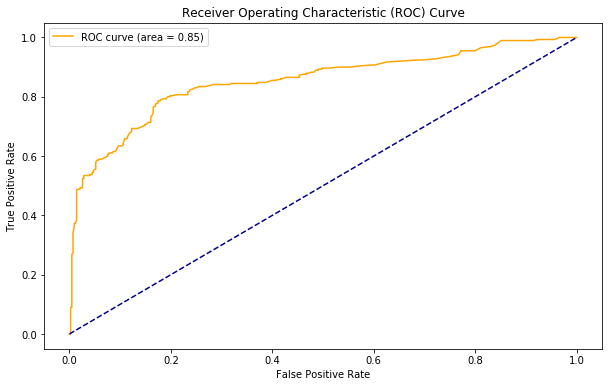

In [25]:
plot_roc_curve(y, yhat)

Podemos considerar uma área debaixo da curva de mais de 0.7 como *aceitável*. Mais de 0.8 parece bom. Mais de .9 está excelente. Há também outras métricas que podemos explorar. 

---

# Predições

Agora vamos fazer predições com nosso modelo?
Vamos prever a nossa probabilidade de sobrevivência no Titanic e também a probabilidade de sobrevivência do coleguinha. Para fazer predições, é importante entrar os dados no modelo com o mesmo formato usado para treino.

In [26]:
eu = pd.DataFrame({'Age':32, 'Pclass_2':0, 'Pclass_3':1, 'Sex_male':1}, index=[0])
minha_prob = model.predict_proba(eu)
print('Eu teria {}% de probabilidade de sobrevivência se estivesse no Titanic'\
      .format(round(minha_prob[:,1][0]*100, 2)))

Eu teria 7.52% de probabilidade de sobrevivência se estivesse no Titanic


In [38]:
coleguinha = pd.DataFrame({'Age':32, 'Pclass_2':0, 'Pclass_3':0, 'Sex_male':1}, index=[0])
prob_do_coleguinha = model.predict_proba(coleguinha)
print('Meu coleguinha teria {}% de probabilidade de sobrevivência se estivesse no Titanic'\
      .format(round(prob_do_coleguinha[:,1][0]*100, 2)))

Meu coleguinha teria 51.77% de probabilidade de sobrevivência se estivesse no Titanic


Ixi... tô lascado...